In [4]:
from common import *

Using TensorFlow backend.


# Load data

In [5]:
model = gensim.models.Word2Vec.load(join(DATA_FOLDER, 'vectors/w2v_model_300_w10'))
wv = model.wv

2017-08-01 10:28:45,026 : INFO : loading Word2Vec object from ../data/vectors/w2v_model_300_w10
2017-08-01 10:28:46,956 : INFO : loading wv recursively from ../data/vectors/w2v_model_300_w10.wv.* with mmap=None
2017-08-01 10:28:46,957 : INFO : loading syn0 from ../data/vectors/w2v_model_300_w10.wv.syn0.npy with mmap=None
2017-08-01 10:28:47,112 : INFO : setting ignored attribute syn0norm to None
2017-08-01 10:28:47,113 : INFO : loading syn1neg from ../data/vectors/w2v_model_300_w10.syn1neg.npy with mmap=None
2017-08-01 10:28:47,275 : INFO : setting ignored attribute cum_table to None
2017-08-01 10:28:47,275 : INFO : loaded ../data/vectors/w2v_model_300_w10


In [6]:
dictionary = corpora.Dictionary.load(join(DATA_FOLDER, 'pure.dict'))
tfidf = models.TfidfModel.load(join(DATA_FOLDER, 'tfidf_pure.model'))
# !!!!!
tfidf.normalize= True

2017-08-01 10:28:48,986 : INFO : loading Dictionary object from ../data/pure.dict
2017-08-01 10:28:50,312 : INFO : loaded ../data/pure.dict
2017-08-01 10:28:50,313 : INFO : loading TfidfModel object from ../data/tfidf_pure.model
2017-08-01 10:28:50,717 : INFO : loaded ../data/tfidf_pure.model


In [7]:
all_docs = get_all_docs(DATA_FOLDER)
val_docs = sorted(glob(join(DATA_FOLDER, 'validate/*.txt')))

In [8]:
all_docs[1022450]

'../data/FIPS/Inventions_applications_txt_output/2f/3e/2010134912A20120227RU.txt'

# Main funcs

In [16]:
def sim_matrix(word_set1, word_set2, wv):
    l1 = list(word_set1)
    l2 = list(word_set2)
    wv1 = wv[l1]
    wv2 = wv[l2]
    
    arr = cosine_similarity(wv1, wv2)
    
    smat = pd.DataFrame(arr, index=l1, columns=l2)
    return smat
    

In [17]:
def wmd(smat, tfidf_weights):
    maxs = np.amax(smat, axis=0)
    return np.dot(maxs, tfidf_weights)

In [18]:
def get_test_tfidf_weights(val_docs, wv):
    tweights = {}
    for fname in tqdm(val_docs):
        with open(fname, 'r') as f:
            doc_text = f.read()
        tokenized_filtered = [w for w in tokenize(doc_text) if w in wv]
        doc_bow = dictionary.doc2bow(tokenized_filtered)
        sorted_tfidf = sorted(tfidf[doc_bow], key=itemgetter(1), reverse=True)
        sorted_tfidf = pd.DataFrame([(dictionary[k],v) for k,v in sorted_tfidf],
                                   columns=['word', 'score'])
        
        name = path.splitext(basename(fname))[0]
        tweights[name] = sorted_tfidf
            
    return tweights

In [19]:
tweights = get_test_tfidf_weights(val_docs, wv)
val_words = set(pd.concat([v.word for v in tweights.values()]))
ziped_files = sorted(glob(DATA_FOLDER + '/documents/*.gz'), key=natural_keys)

100%|██████████| 130/130 [00:00<00:00, 189.16it/s]


In [20]:
# tweights['_01_98_2010120931A10010101RU']

In [21]:
def doc_queries_distances(d_smat, tweights):
    dists = []
    for k, query in tweights.items():
        if len(query) == 0:
            dists.append(None)
            continue
        
        qsmat = d_smat.loc[:, query.word]
        dist = wmd(qsmat, query.score)
        dists.append(dist)
    return dists


def _calc(docs):        
    doc_dists = []
    words = set([w for doc in docs for sent in doc for w in sent if w in wv])
    smat = sim_matrix(words, val_words, wv)
    for doc in tqdm(docs):
        doc_words = set([w for sent in doc for w in sent])
        d_smat = smat.loc[doc_words, :]
        dists = doc_queries_distances(d_smat, tweights)

        doc_dists.append(dists)
    return doc_dists


def calc_dists(fnames, wv):
    doc_dists = []
    for fn in fnames:
        print(fn)
        ! echo {fn} >> ../data/out
        with GzipFile(fn, 'r') as myzip:
            text = myzip.read()
        docs = json.loads(text)
        
        parallelizer = Parallel(n_jobs=cpu_count)

        # this iterator returns the functions to execute for each task
        tasks_iterator = ( delayed(_calc)(docs_block) for 
                          docs_block in grouper(len(docs)//cpu_count, docs) )  
        result = parallelizer( tasks_iterator )        
        doc_dists += result
            
    return np.array(sum(doc_dists, []))

In [128]:
val_dists = calc_dists(ziped_files[:1], wv)

../data//documents/0.json.gz


100%|██████████| 298/298 [01:49<00:00,  4.37it/s]


In [132]:
np.save(join(DATA_FOLDER, 'val_dists.npy'), val_dists)

In [67]:
val_dists = np.load(join(DATA_FOLDER, 'val_dists.npy'))

In [68]:
sorted_args = val_dists.argsort(axis=0)[-20000000:][::-1]

In [63]:
sorted_args = np.load(join(DATA_FOLDER, 'sorted_args_200.npy'))

In [64]:
sorted_args

array([[1022450, 1022450, 1022450, ..., 1022450, 1022450, 1022450],
       [ 291479,  756153, 1036047, ...,  141303,   97013,  446979],
       [ 449466,  183979,  449466, ...,  226883,  449466,  287118],
       ..., 
       [ 510153, 1041255,  526974, ...,  343878,  393105,  136507],
       [ 324196,  228566,  304550, ...,  499947,   16965,  522205],
       [ 164849,  793717,  351308, ...,  260310,  300050,  268891]])

In [86]:
best = {}
for i in range(sorted_args.shape[1]):
    col = sorted_args[:,i]
    name = path.splitext(basename(val_docs[i]))[0]
    top = []
    for j,c in enumerate(col):
        top.append(path.splitext(basename(all_docs[c]))[0])
    best[name] = top

In [84]:
with open(join(DATA_FOLDER, 'gold.json'), 'r') as f:
    gold = json.load(f)

median
acc10     0.0
acc20     0.0
acc200    0.1
dtype: float64
mean
acc10     0.190000
acc20     0.220769
acc200    0.403718
dtype: float64


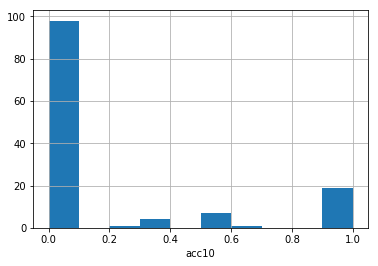

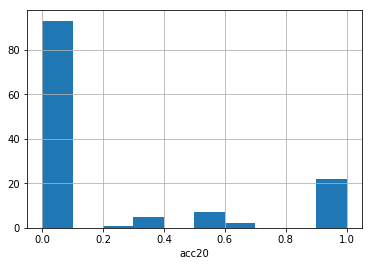

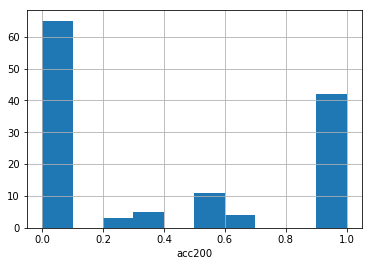

In [87]:
res = evaluate(best, gold)

In [142]:
send_email(notebook_url, body='Finished')

Successfully sent email


TODO:
* normalize = False in tfidf
* first 2-3 sents of query

# Check

In [54]:
fn = [fn for fn in all_docs if '0000009123U119990216RU' in fn][0]
all_docs.index(fn)

1133172

In [62]:
!cat {fn}

одежда с электронагревательный ткань  . 
 1 .
 предмет одежда с электрообогрев , содержать внешний слой одежда , источник электроэнергия и по меньший мера один нагревательный элемент , закреплять съемный образ на внутренний сторона внешний слой одежда , снабжать средство разъемный соединение с источник электропитание , отличать тем , что упоминать по меньший мера один нагревательный элемент выполнять в вид участок электронагревательный ткань из электропроводить углеродный нить и фоновый изоляционный нить из естественный или синтетический волокно , при этот упоминать нагревательный элемент размещать с максимальный приближение к нагревать поверхность человеческий тело и с максимальный удаление от внешний среда на участок внутренний сторона внешний слой одежда , выбирать с учет распределение температура на поверхность тело и свойство система кровообращение пользователь .
 2 .
 предмет одежда по п.1 , отличать тем , что в качество участок для размещение нагревательный элемент выбирать учас

In [73]:
!cat {all_docs[291479]}

электростанция и способ получение энергия с комбинирование цикл  . 
 изобретение относиться к область энергетик .
 предлагать электростанция и способ производство энергия по принцип комбинирование цикл , обеспечивать повышение удельный производительность и гибкость эксплуатационный параметр электростанция , причем без соответствующий увеличение ее тепловой мощность .
 процесс улучшение термический кпд комбинированный цикл мочь обеспечивать за счет стратегия использование дополнительный топливо и/или подведение тепло .
 в частность , газовый турбина , выхлоп из который поступать в парогенератор регенерация тепло , мочь обогревать дополнительно .
 предлагать система в целый обеспечивать высокий эффективность электростанция с комбинирование цикл преимущественно за счет цикл ренкайна ( нижний ) .
 модель реализация изобретение включать нагрузка , ведомый двигатель верхний цикл , приводить в действие жидкость верхний цикл , сбрасывать в устройство для регенерация тепло .
 устройство для рег

 независимо от тот , использоваться ли природный газ , нефть или иной горючий вид топливо , электростанция с комбинирование цикл для производство большой количество электричество должный потр��блять большой количество топливо .
 короткий говорить , электростанция фактически преобразовать энергия в один форма ( сырье ) в энергия в другой форма ( электричество ) .
 по этот причина , так как функция электростанция являться осуществление данный преобразование , эффективность процесс преобразование являться ключ к экономический успех электростанция .
 электростанция предшествовать уровень техника иметь мощность в средний около 48% ( lhv ) для более старый электростанция с комбинирование цикл , как , например , general electric s106b , и до 60% ( lhv ) для предполагаемый усовершенствованный модель general electric s107h , который еще не быть реализовать в коммерческий вариант .
 указанный уровень мощность основываться на коэффициент низший теплоотдача топливо ( lhv ) .
 однако такой уровень 

In [39]:
! cat {val_docs[0]}

﻿способ экономия электроэнергия .
 изобретение относиться к проблема экономия электроэнергия , как один из весомый в программа борьба с глобальный потепление климат , и эффективный мочь быть применять , как это ни показаться неожиданный , в область кулинарный хозяйство .
 проблема с электроэнергия возникнуть сразу же после изобретение в 1879 г . гениальный томас альва эдисон электрический лампа накаливание .
 при ее запиток от использовать тогда источник постоянный ток , недопустимый большой быть потеря в линия передача на большой расстояние .
 проблема быть устранять в 1887 г . один из великий физик современность никола теслый , свой изобретение генератор переменный ток и высоковольтный трансформатор .
 дальнейший нововведение , как и этот , подстраиваться , в основной , к электрический характеристика объект запиток , как правило не учитывать они физический особенность .
 в кулинария экономия затрачивать энергия не являться главенствующий фактор , но неизменный оставаться только стрем

In [14]:
val_docs[0]

'../data/validate/_01_98_2010120931A10010101RU.txt'

In [22]:
tweights['_01_98_2010120931A10010101RU']

,word,score
0,экономия,0.419251
1,кулинария,0.253144
2,электроэнергия,0.234901
3,томить,0.218281
4,блюдо,0.196800
5,старинный,0.183828
6,запиток,0.150455
7,кухня,0.134959
8,настаивать,0.132950
9,бытовой,0.130700


In [74]:
with open(all_docs[291479]) as f:
    text = f.read()
doc = []
for sent in nltk.sent_tokenize(text):
    doc.append(list(tokenize(sent)))

In [75]:
words = set([w for s in doc for w in s if w in wv])
smat = sim_matrix(words, val_words, wv)

query = tweights['_01_98_2010120931A10010101RU']
qsmat = smat.loc[:, query.word]
dist = wmd(qsmat, query.score)
dist


7.6595471846288907

In [76]:
qsmat

,экономия,кулинария,электроэнергия,томить,блюдо,старинный,запиток,кухня,настаивать,бытовой,...,необходимый,скорость,выбирать,проводить,давление,вода,температура,область,технический,отличать
вызов,0.217465,0.161199,0.242670,0.075868,0.127202,0.149905,0.189551,0.160055,0.076687,0.187991,...,0.183883,0.146342,0.157984,0.046621,0.139145,0.104384,0.079902,0.148272,0.118810,0.062306
повышенный,0.301151,0.211663,0.274041,0.195878,0.268541,0.239716,0.126610,0.173666,0.136320,0.181066,...,0.438369,0.240450,0.153139,0.226737,0.307556,0.250300,0.298493,0.184882,0.398993,0.261674
приоритет,0.159485,0.126645,0.281104,0.093155,0.106368,0.160361,0.140222,0.185555,0.073804,0.144400,...,0.174932,0.137545,0.218005,0.098132,0.080932,0.117578,0.130503,0.094190,0.256889,0.066603
жидкость,0.168513,0.168104,0.165688,0.226853,0.118112,0.082896,0.208164,0.163501,0.245480,0.166890,...,0.324379,0.254766,0.098485,0.168968,0.408649,0.490672,0.301820,0.162426,0.211580,0.264903
возвращение,0.312045,0.105250,0.290808,0.167389,0.194703,0.191349,0.278023,0.166383,0.246451,0.263037,...,0.404499,0.238588,0.097019,0.224931,0.308573,0.250417,0.202719,0.082893,0.221204,0.251562
преобразоваться,0.185835,0.150457,0.325504,0.050798,0.094482,0.112609,0.299400,0.081198,0.080824,0.126161,...,0.300714,0.246431,0.121154,-0.017046,0.150253,0.129772,0.160533,0.136377,0.107537,0.157600
нехватка,0.435245,0.214750,0.398121,0.245478,0.153019,0.179060,0.153526,0.201881,0.197763,0.251316,...,0.439027,0.187583,0.091322,0.088759,0.204684,0.217871,0.203452,0.240622,0.171825,0.091275
секционный,0.234621,0.119149,0.284678,0.187407,0.208795,0.150223,0.308277,0.194127,0.149338,0.243767,...,0.313342,0.212057,-0.002153,0.251119,0.226702,0.211644,0.207178,0.141334,0.337603,0.294311
распылительный,0.171437,0.188328,0.176723,0.251573,0.072008,0.138093,0.101500,0.245562,0.120228,0.183019,...,0.207352,0.152332,0.132372,0.179313,0.254100,0.318560,0.250258,0.112730,0.132045,0.236533
месяц,0.177506,0.178267,0.150464,0.300896,0.140227,0.148050,0.046079,0.092225,0.305674,0.136268,...,0.183127,0.125969,0.087074,0.330025,0.174780,0.219236,0.193171,0.125546,0.147990,0.136862


In [80]:
qsmat['томить'].argmax()

'настаивать'

In [78]:
maxs = np.amax(qsmat, axis=0)
maxs.sort_values(ascending=False)
# np.dot(maxs, tfidf_weights)

пользователь     1.000000
хотеться         1.000000
проверенный      1.000000
окончательный    1.000000
неизменный       1.000000
участок          1.000000
потепление       1.000000
скорость         1.000000
томас            1.000000
трансформатор    1.000000
подобный         1.000000
правило          1.000000
частота          1.000000
объект           1.000000
район            1.000000
тепловой         1.000000
кипеть           1.000000
рассматривать    1.000000
циклический      1.000000
точно            1.000000
проблема         1.000000
выбирать         1.000000
эдисон           1.000000
естественный     1.000000
толстый          1.000000
источник         1.000000
электрический    1.000000
нагревание       1.000000
отличать         1.000000
борьба           1.000000
                   ...   
разгон           0.560925
водитель         0.553282
прерывание       0.550648
физик            0.542234
показаться       0.540417
напр             0.533813
электро          0.533554
одноразовост

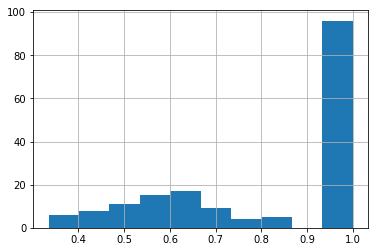

count    171.000000
mean       0.819735
std        0.220412
min        0.334832
25%        0.606155
50%        1.000000
75%        1.000000
max        1.000000
dtype: float64


In [79]:
maxs.hist()
plt.show()
print(maxs.describe())

**Чем больше документ, тем больше вероятность что в нем найдутся близкие слова к запросу**

Как с этим бороться:

* взять первых несколько (top 3) предложений в запросе и документе, взять, так сказать, суть
* привести все документы к одинаковому количеству слов. Можно взять топ 15 слов по tfidf из запроса и документа.


# First n

In [19]:
fn = join(DATA_FOLDER, 'first3.json.gz')

with GzipFile(fn, 'r') as myzip:
    text = myzip.read()
docs = json.loads(text)
del text

In [87]:
fn = join(DATA_FOLDER, 'first3_val.json.gz')

with GzipFile(fn, 'r') as myzip:
    text = myzip.read()
val_documents = json.loads(text)
del text

In [88]:
len(val_documents)

130

In [90]:
!cat {val_docs[0]}

﻿способ экономия электроэнергия .
 изобретение относиться к проблема экономия электроэнергия , как один из весомый в программа борьба с глобальный потепление климат , и эффективный мочь быть применять , как это ни показаться неожиданный , в область кулинарный хозяйство .
 проблема с электроэнергия возникнуть сразу же после изобретение в 1879 г . гениальный томас альва эдисон электрический лампа накаливание .
 при ее запиток от использовать тогда источник постоянный ток , недопустимый большой быть потеря в линия передача на большой расстояние .
 проблема быть устранять в 1887 г . один из великий физик современность никола теслый , свой изобретение генератор переменный ток и высоковольтный трансформатор .
 дальнейший нововведение , как и этот , подстраиваться , в основной , к электрический характеристика объект запиток , как правило не учитывать они физический особенность .
 в кулинария экономия затрачивать энергия не являться главенствующий фактор , но неизменный оставаться только стрем

In [47]:
tweights = {}
for fname, doc in tqdm(zip(val_docs, val_documents)):
    tokenized_filtered = [w for w in doc if w in wv]
    doc_bow = dictionary.doc2bow(tokenized_filtered)
    sorted_tfidf = sorted(tfidf[doc_bow], key=itemgetter(1), reverse=True)
    sorted_tfidf = pd.DataFrame([(dictionary[k],v) for k,v in sorted_tfidf],
                               columns=['word', 'score'])

    name = path.splitext(basename(fname))[0]
    tweights[name] = sorted_tfidf

val_words = set(pd.concat([v.word for v in tweights.values()]))

130it [00:00, 1610.34it/s]


In [48]:
val_dists = calc_dists(ziped_files[:1], wv)

../data//documents/0.json.gz


100%|██████████| 298/298 [01:56<00:00,  4.08it/s]


In [2]:
notebook_url

'http://localhost:8888/notebooks/Documents/iteco/pat/query%20expansion.ipynb#'